In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os

In [2]:
from arch import arch_model

In [3]:
ini_work_dir = os.getcwd()
os.chdir('..')

In [4]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params
from local_models import calculate_retraining_garch_forecasts

In [5]:
with open('config.json') as file:
    config = json.load(file)

In [6]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']
metadata_file_name = 'current_antecedent_fitting_metadata_seasonal.pkl'
logs_folder = config['files_folders']['logs']
summary_table_name = 'summary_table_seas'

In [7]:
logger = logging.getLogger('apf_seas_nb')  # apf == antecedent params fitting

_log_file = f'{logs_folder}/apf_seas_nb.log'
logging.basicConfig(level=logging.DEBUG,
                    filename=_log_file,
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

# Reading data

In [8]:
with open(f'{antecedent_params_folder}/{metadata_file_name}', 'rb') as file:
    data = pickle.load(file)

In [9]:
train = data['train']
test = data['test']
consequent_metaparams = data['consequent_metaparams']
consequent_params_ini = data['consequent_metaparams']['parameters_ini']
antecedent_params_set = data['antecedent_params_set']
clusterization_method = data['clusterization_method']
local_method = data['local_method']
data_to_cluster_train = data['data_to_cluster_train']
data_to_cluster_test = data['data_to_cluster_test']
cluster_sets_conjunction = data['cluster_sets_conjunction']
n_last_points_to_use_for_clustering = data['n_last_points_to_use_for_clustering']
other_fvm_parameters = data['other_fvm_parameters']

In [10]:
n_cluster_sets = len(data['clusterization_method'])

p = consequent_metaparams['p']
q = consequent_metaparams['q']

n_train = train.shape[0]
n_test = test.shape[0]

# Main input data plot

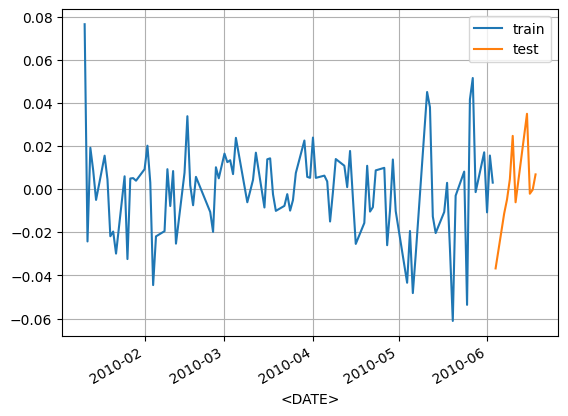

In [11]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

# Vanilla GARCH errors

### No retraining

In [12]:
garch_mean = 'Zero'
garch_dist = 'normal'
garch_vol = 'GARCH'

garch = arch_model(train,
                   mean=garch_mean,
                   vol=garch_vol,
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -172.81375246629065
Iteration:      2,   Func. Count:     14,   Neg. LLF: -231.83780274495433
Iteration:      3,   Func. Count:     21,   Neg. LLF: -246.87441129590061
Iteration:      4,   Func. Count:     28,   Neg. LLF: -246.6371189750122
Iteration:      5,   Func. Count:     33,   Neg. LLF: -250.4869892567008
Iteration:      6,   Func. Count:     37,   Neg. LLF: -250.4870954083915
Iteration:      7,   Func. Count:     41,   Neg. LLF: -250.4871000056945
Iteration:      8,   Func. Count:     44,   Neg. LLF: -250.4871000055288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -250.4871000056945
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


/Applications/anaconda3/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004542. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [13]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [14]:
mse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=True)
rmse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=False)
mape = mean_absolute_percentage_error(simple_garch_forecasts, test ** 2)

garch_errors = {'mse': mse, 'rmse': rmse, 'mape': mape}
garch_errors

{'mse': 2.901720753924943e-07,
 'rmse': 0.0005386762250113646,
 'mape': 0.918846246229198}

In [26]:
result['Vanilla GARCH n/r errors'] = garch_errors

TypeError: 'NoneType' object does not support item assignment

### W/ retraining

In [27]:
retraining_garch_forecasts = calculate_retraining_garch_forecasts(train, test,
                                                                  mean=garch_mean,
                                                                  vol=garch_vol,
                                                                  p=p,
                                                                  q=q,
                                                                  dist=garch_dist)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 339.79497867590567
Iteration:      2,   Func. Count:     11,   Neg. LLF: 221.7008723240183
Iteration:      3,   Func. Count:     19,   Neg. LLF: 217.90035028275037
Iteration:      4,   Func. Count:     25,   Neg. LLF: 213.47989304843512
Iteration:      5,   Func. Count:     30,   Neg. LLF: 212.96053697166812
Iteration:      6,   Func. Count:     34,   Neg. LLF: 212.96032123329528
Iteration:      7,   Func. Count:     38,   Neg. LLF: 212.96030965397787
Iteration:      8,   Func. Count:     42,   Neg. LLF: 212.96030902627993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 212.96030902627993
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 390.85669049574915
Iteration:      2,   Func. Count:     11,   Neg. LLF: 223.9331981501103
Iteration:      3,   Func. Count:     19,   Neg. LLF: 220.327625

In [28]:
_mse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=True)
_rmse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=False)
_mape = mean_absolute_percentage_error(retraining_garch_forecasts, test ** 2)

retr_garch_errors = {'mse': _mse, 'rmse': _rmse, 'mape': _mape}
retr_garch_errors

{'mse': 21.4880189836119, 'rmse': 4.635517121488379, 'mape': 0.915450308599018}

In [29]:
result['Vanilla GARCH w/r errors'] = retr_garch_errors

TypeError: 'NoneType' object does not support item assignment